In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
import re
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from google.cloud import bigquery

from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np

import seaborn as sns

In [2]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '~/.config/gcloud/application_default_credentials.json'

Commenting out data pull cells for now and loading from pickle file below

credential_path = "/home/jeremy/Desktop/projects/reddit/reddit AITA-2991631ea459.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

client = bigquery.Client()

# Perform a query.
QUERY = ("""
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_08`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_07`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2 
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_06`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_05`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_04`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_03`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_02`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
            
            UNION DISTINCT
            
            SELECT * 
            FROM `fh-bigquery.reddit_posts.2019_01`
            WHERE subreddit = 'AmItheAsshole'
            and score > 10
            and num_comments > 2
        """)
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish

# for row in rows:
#     print(row.name)
df = query_job.to_dataframe()
df.shape

df.to_pickle('/home/jeremy/Desktop/projects/data/Annotation/reddit_aita_2019_08.pickle')                  #('reddit_aita_2019_08.pickle')

In [3]:
jeremy_filepath = '/home/jeremy/Desktop/projects/data/Annotation/reddit_aita_2019_08.pickle'
audrey_filepath = ''

In [4]:
df = pd.read_pickle(jeremy_filepath)

In [5]:
df['title_length'] = [len(x.split()) for x in df['title']]
df['post_length'] = [len(x.split()) for x in df['selftext']]

In [6]:
df.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length
0,1546561653,AmItheAsshole,TheEvilBunnyLord,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,38,48,None,None,AITA for kicking someone out over spoilers?,"More specifically, that and their attitude aft...",None,acc9wk,None,0,None,False,1552583264,False,self,t5_2xhvq,None,not,,False,True,None,/r/AmItheAsshole/comments/acc9wk/aita_for_kick...,None,Partassipant [1],False,Not the A-hole,None,7,483
1,1546622482,AmItheAsshole,espectro11,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,24,42,None,None,AITA For telling my wife that her sister and b...,We have a 18 month year old and we are fine th...,None,ackb2l,None,0,None,False,1552587055,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/ackb2l/aita_for_tell...,None,None,False,Not the A-hole,None,15,188
2,1546616783,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,49,47,None,None,AITA I don’t want my schizophrenic drug addict...,[deleted],None,acjcpy,None,0,None,False,1552586600,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/acjcpy/aita_i_dont_w...,None,None,False,Not the A-hole,None,14,1
3,1546645755,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,215,58,None,None,AITA for not letting my girlfriend bring a dog...,[deleted],None,acoaft,None,0,None,False,1552588918,False,default,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/acoaft/aita_for_not_...,None,None,False,Not the A-hole,None,12,1
4,1546444100,AmItheAsshole,Thowingitawayagain5,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,208,213,None,None,AITA for breaking up with my gf because I don'...,I have been together with my gf for over a yea...,None,abuiv6,None,0,None,False,1552574939,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/abuiv6/aita_for_brea...,None,None,False,No A-holes here,None,15,298


In [7]:
# these stats are only for posts with at least 10 net upvotes and 2 comments as per data pull
df.describe()

,created_utc,num_comments,score,gilded,retrieved_on,title_length,post_length
count,3.571800e+04,35718.000000,35718.000000,35718.000000,3.571800e+04,35718.000000,35718.000000
mean,1.558535e+09,151.300157,609.736295,0.018534,1.562499e+09,12.765776,257.742483
std,5.622921e+06,401.782993,2595.037754,0.223850,4.719946e+06,5.099422,218.639703
min,1.546302e+09,3.000000,11.000000,0.000000,1.552567e+09,1.000000,0.000000
25%,1.554074e+09,25.000000,17.000000,0.000000,1.560320e+09,9.000000,1.000000
50%,1.559088e+09,45.000000,41.000000,0.000000,1.561077e+09,12.000000,244.000000
75%,1.563479e+09,107.000000,189.000000,0.000000,1.566769e+09,15.000000,410.000000
max,1.567295e+09,10655.000000,66384.000000,20.000000,1.567381e+09,64.000000,2433.000000


In [8]:
# pretty massive amount of posts with basically zero engagement, 
# I think if we look at the upper quartile of posts it will be more substantive as a representation of the sub
aita = df.loc[(df['score'] >= 25) & (df['num_comments'] >= 5)].copy()

# cutting some of the uncommon labels.. might want to leave them in
aita = aita[aita['link_flair_text'].isin(['Not the A-hole', 'Asshole', 'No A-holes here', 'Everyone Sucks'])]

# Create a new column 'category_id' with encoded categories 
aita['label_id'] = aita['link_flair_text'].factorize()[0]

label_id_df = aita[['link_flair_text', 'label_id']].drop_duplicates()

# Dictionaries for future use
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id', 'link_flair_text']].values)

print(label_to_id)

aita.shape

{'Not the A-hole': 0, 'No A-holes here': 1, 'Asshole': 2, 'Everyone Sucks': 3}


(18554, 36)

In [9]:
# overwhelming majority of posts are Not the A-hole
aita.groupby('link_flair_text').size().sort_values(ascending = False)

link_flair_text
Not the A-hole     11658
Asshole             3959
No A-holes here     1958
Everyone Sucks       979
dtype: int64

Text(0.5, 1.0, 'score')

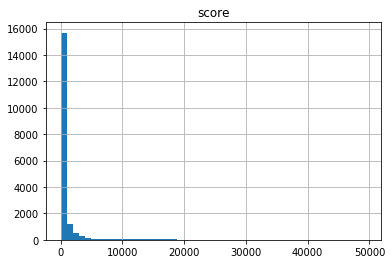

In [10]:
aita['score'].hist(bins = 50);
plt.title('score')

Text(0.5, 1.0, 'num_comments')

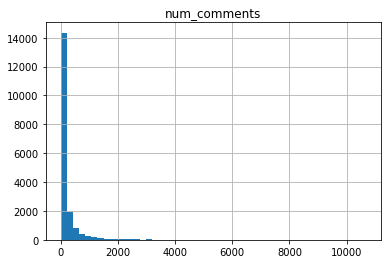

In [11]:
aita['num_comments'].hist(bins = 50);
plt.title('num_comments')

In [12]:
# how many accounts are "throwaway accounts"
# eh.... less than 1/15
# ton of people are deleting their accounts
print(aita['author'].nunique())
print(aita.loc[(aita['author'].str.contains('throwaway') | aita['author'].str.contains('throw_away')) | (aita['author'] == '[deleted]')]['author'].nunique())
aita.loc[(aita['author'].str.contains('throwaway') | aita['author'].str.contains('throw_away')) | (aita['author'] == '[deleted]')]['author'].value_counts().sort_values(ascending = False)

15631
937


[deleted]              2338
hxghh_throwaway           4
throwawayorisit69         4
LakeOswegothrowaway       3
throwaway373637           2
                       ... 
throwawayogissues         1
Backupthrowaway117        1
throwaway12938762         1
Yarnthrowaway             1
throwaway838383393        1
Name: author, Length: 937, dtype: int64

In [13]:
# has anyone been the asshole multiple times?
# lol chemistrynerd1994
assholes = pd.DataFrame(aita[aita['link_flair_text'] == 'Asshole']['author'].value_counts())
assholes.head(10)

,author
[deleted],523
chemistrynerd1994,3
scaredoftheirlove,2
drflanigan,2
roseroserose___,2
GHuntsmann,2
LakeOswegothrowaway,2
straffknullamig,2
hemantheinnocent,2
bookbanningbrother,2


In [14]:
#who was the biggest asshole?
# don't have comment count right now....
aita[aita['link_flair_text'] == 'Asshole'].head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id
16,1550281506,AmItheAsshole,citadelinn,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,96,318,None,None,AITA for being annoyed with my cat?,...or is my cat the asshole?\n\n\nHis name is ...,None,ar3x78,None,0,None,False,1553190824,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/ar3x78/aita_for_bein...,None,None,False,Asshole,None,7,703,2
40,1547340121,AmItheAsshole,[deleted],self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,73,41,None,None,AITA for wanting an open relationship,"So, I (F, 22) have been in a relationship with...",None,afdtcm,None,0,None,False,1552634756,True,nsfw,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/afdtcm/aita_for_want...,None,None,False,Asshole,None,6,1113,2
44,1551592000,AmItheAsshole,First_Land,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,94,84,None,None,AITA for being upset that I'm being excluded f...,Obvious throwaway because my SO knows my reddi...,None,awr3qn,None,0,None,False,1560120548,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/awr3qn/aita_for_bein...,None,None,False,Asshole,None,14,500,2
56,1549719445,AmItheAsshole,HourKnowledge,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,242,574,None,None,WIBTA if I broke up with my amazing boyfriend ...,I'm a legal secretary. I love what I do and I'...,None,aosdov,None,0,None,False,1553044422,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/aosdov/wibta_if_i_br...,None,None,False,Asshole,None,13,618,2
73,1548416565,AmItheAsshole,AccurateCook4,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,87,61,None,None,AITA for forgetting my best friend's wife's bi...,Last week I got an angry text from my best fri...,None,ajo7yu,None,0,None,False,1552707201,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/ajo7yu/aita_for_forg...,None,None,False,Asshole,None,8,221,2


In [15]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemmas)

In [16]:
# aita['proc_title'] = [x.lower() for x in aita['title']]
# aita['proc_title'] = [s.translate(string.punctuation) for s in aita['proc_title']]
aita['proc_title'] = [preprocess(x) for x in aita['title']]
aita['proc_text'] = [preprocess(x) for x in aita['selftext']]

aita['proc_title'] = [x.replace('aita', '') for x in aita['proc_title']]
aita['proc_title'] = [x.replace('wibta', '') for x in aita['proc_title']]
# x200b
aita['proc_text'] = [x.replace('aita', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('wibta', '') for x in aita['proc_text']]
aita['proc_title'] = [x.replace('asshole', '') for x in aita['proc_title']]
aita['proc_text'] = [x.replace('asshole', '') for x in aita['proc_text']]

In [17]:
aita.sort_values('num_comments', ascending = False, inplace = True)
aita.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length,label_id,proc_title,proc_text
2714,1561592428,AmItheAsshole,nipslip911,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,10655,19388,None,None,AITA for giving my concert ticket to another g...,"I am 24M and I have a friend who is 21, she is...",None,c5y237,None,1,None,False,1566765738,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/c5y237/aita_for_givi...,None,None,False,Asshole,None,22,514,2,giving concert ticket another girl friend sai...,24m friend 21 really nice known year sister ac...
16163,1566910725,AmItheAsshole,isaoas,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,8858,33899,None,None,AITA for refusing to pay back my cousin after ...,"Hi all. \n\nI gave birth four weeks ago, and w...",None,cw43oc,None,2,None,False,1566997107,False,self,t5_2xhvq,None,not,None,None,True,None,/r/AmItheAsshole/comments/cw43oc/aita_for_refu...,None,None,False,Not the A-hole,None,14,271,0,refusing pay back cousin baby ruined blouse,hi gave birth four week ago decided baby cerem...
32375,1557397698,AmItheAsshole,mydogismygod0,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,8156,28004,None,None,AITA for cancelling my wedding because fiancee...,Me (28M) and fiancee (27F) have been together ...,None,bmi2qj,None,1,None,False,1560678368,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/bmi2qj/aita_for_canc...,None,None,False,Everyone Sucks,None,12,670,3,cancelling wedding fiancee almost got dog killed,28m fiancee 27f together 4 year engaged 6 mont...
32532,1563291671,AmItheAsshole,aljsdhnrthrow,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,7964,38942,None,None,AITA for telling cashier that wasn’t the girls...,\nThrowaway because husband told me I was TA a...,None,cdypge,None,1,None,False,1566935184,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/cdypge/aita_for_tell...,None,None,False,Asshole,None,10,425,2,telling cashier girl credit card,throwaway husband told ta want know get home a...
27425,1563988805,AmItheAsshole,broken_inside_me,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,7804,31646,None,None,"AITA for kicking out my brother, who our paren...","For reference, my brother Connor is 19, I am 2...",None,chb37s,None,2,None,False,1567013658,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/chb37s/aita_for_kick...,None,None,False,Everyone Sucks,None,25,408,3,kicking brother parent previously disowned to...,reference brother connor 19 26 ex fiancé hunte...


In [26]:
# save the processed df in case the notebook crashes
jeremy_processed_fp = '/home/jeremy/Desktop/projects/data/Annotation/processed_aita_2019_08.pickle'
aita.to_pickle(jeremy_processed_fp)

In [18]:
aita.iloc[0]['selftext']

'I am 24M and I have a friend who is 21, she is really nice and we\'ve known each other for a year. She is my sister\'s acquaintance and we met at my sister\'s birthday party. I have a crush on her although she isn\'t exactly my type. Lately I feel like I\'ve been getting vibes that she likes me back.\n\nLast week I won a raffle and have 2 tickets to see a famous singer perform next month in a nearby city. She also happens to like this singer so I asked her if she wanted to go with me as a date. I said I can book us a hotel room and we can spend the night together. She said she\'d love to go, but only as friends. She says she\'s alright with us splitting a hotel room as long as it has two beds. She told me she doesn\'t feel ready to date anyone at the moment, and she doesn\'t do flings either, so unfortunately we can only be platonic friends. I said I\'ll think about it. I was quite hurt because honestly I don\'t have much experience with rejection, and I was annoyed that she turned me

In [19]:
aita.iloc[0]['proc_text']

'24m friend 21 really nice known year sister acquaintance met sister birthday party crush although exactly type lately feel like getting vibe like back last week raffle 2 ticket see famous singer perform next month nearby city also happens like singer asked wanted go date said book u hotel room spend night together said love go friend say alright u splitting hotel room long two bed told feel ready date anyone moment fling either unfortunately platonic friend said think quite hurt honestly much experience rejection annoyed turned today asked female coworker go concert date immediately said yes seemed quite excited although admitted never listened song still taking drink friday friend asked originally asked still concert told honestly already asked another woman seemed disappointed dropped subject told sister happened said really douchy say friend huge fan singer take instead coworker even like band want go like said understand dude let honest choice going girl want friend versus girl su

In [20]:
aita['link_flair_text'].unique()

array(['Asshole', 'Not the A-hole', 'Everyone Sucks', 'No A-holes here'],
      dtype=object)

In [21]:
aita['link_flair_text'].value_counts()

Not the A-hole     11658
Asshole             3959
No A-holes here     1958
Everyone Sucks       979
Name: link_flair_text, dtype: int64

In [22]:
# I should double check.. I think with factorize() this order can change if I change the data pull
asshole_text = " ".join(aita.loc[(aita['label_id'] == 0)]['proc_text'])
nta_text = " ".join(aita.loc[(aita['label_id'] == 1)]['proc_text'])
na_text = " ".join(aita.loc[(aita['label_id'] == 2)]['proc_text'])
es_text = " ".join(aita.loc[(aita['label_id'] == 3)]['proc_text'])

In [23]:
es_text[:100]

'28m fiancee 27f together 4 year engaged 6 month also 7 year old lab mix greatest dog existence satur'

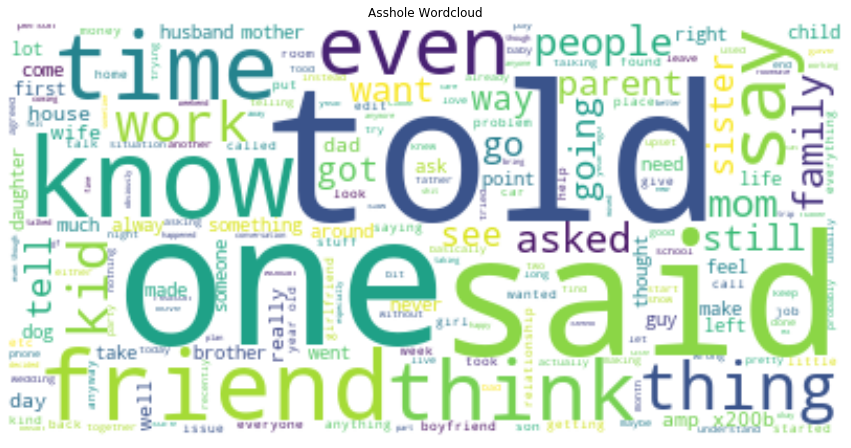

In [19]:
wordcloud = WordCloud( background_color="white").generate(asshole_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Asshole Wordcloud')
plt.show()

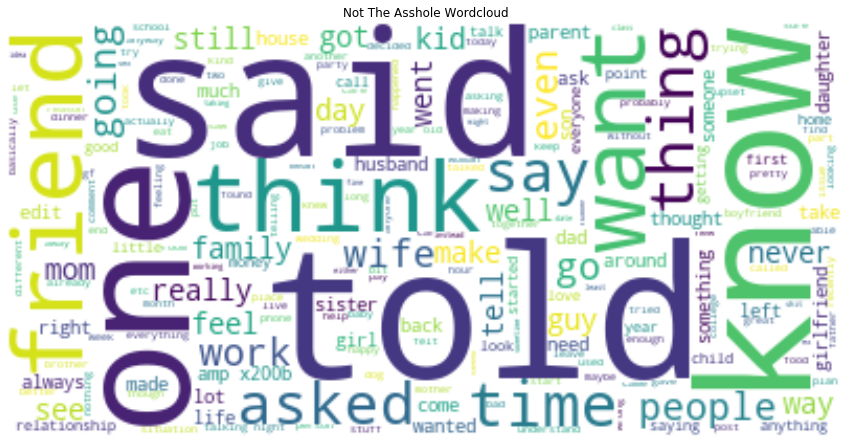

In [20]:
wordcloud = WordCloud( background_color="white").generate(nta_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Not The Asshole Wordcloud')
plt.show()

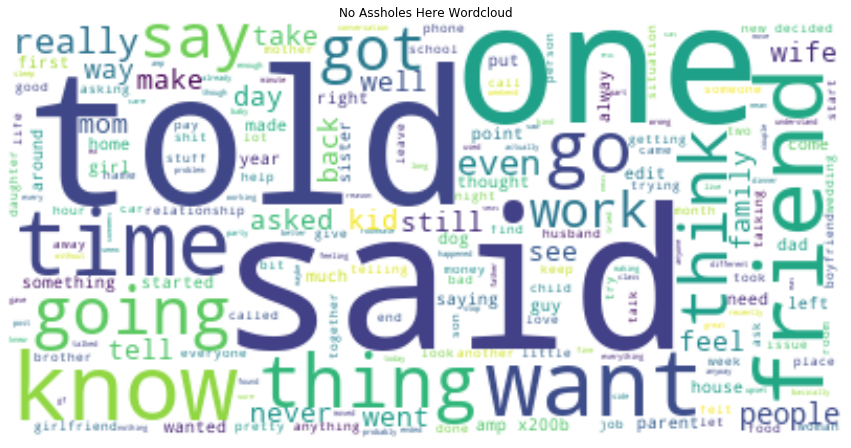

In [21]:
wordcloud = WordCloud( background_color="white").generate(na_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('No Assholes Here Wordcloud')
plt.show()

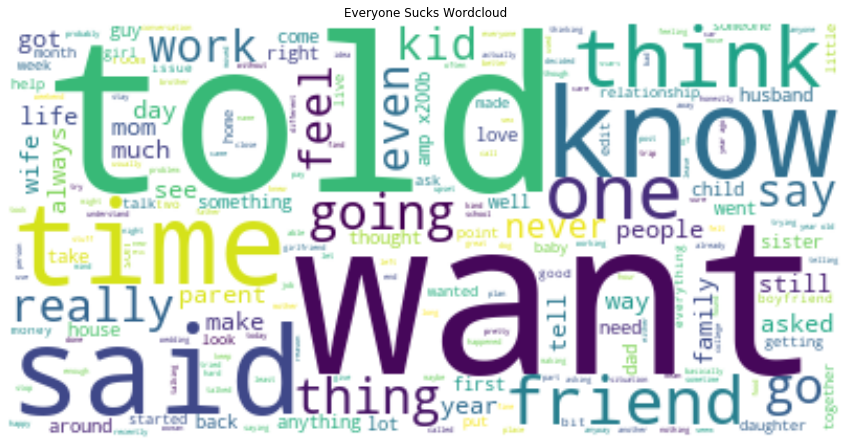

In [22]:
wordcloud = WordCloud( background_color="white").generate(es_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Everyone Sucks Wordcloud')
plt.show()

TF - IDF work here. Hard to differentiate between labels as they're mostly using the same words and same scenarios and context is the main determiner

## Here's some modeling stuff, I pulled into a new notebook though because I was running out of RAM

In [26]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(aita['proc_text']).toarray()

labels = aita.label_id

print("Each of the %d posts is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 18554 posts is represented by 72658 features (TF-IDF score of unigrams and bigrams)


In [28]:
# Finding the three most correlated terms with each of the product categories
N = 3
for label, label_id in sorted(label_to_id.items()):
  features_chi2 = chi2(features, labels == label_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(label))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Asshole:
  * Most Correlated Unigrams are: wife, edit, removed
  * Most Correlated Bigrams are: edit alright, edit ok, edit okay

==> Everyone Sucks:
  * Most Correlated Unigrams are: megan, swerved, removed
  * Most Correlated Bigrams are: late lunch, said lost, blocked phone

==> No A-holes here:
  * Most Correlated Unigrams are: removed, barb, lily
  * Most Correlated Bigrams are: brother died, sex reason, said biggest

==> Not the A-hole:
  * Most Correlated Unigrams are: mom, wife, removed
  * Most Correlated Bigrams are: accept judgement, edit ok, edit okay


In [29]:
# Train Test Split
X = aita['proc_text'] # Collection of documents
y = aita['label_id'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

## Model Fitting

In [1]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto'),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

NameError: name 'RandomForestClassifier' is not defined

In [ ]:


mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc



In [ ]:


plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

